In [1]:
# IMPORT MODULES

import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


(37229, 9)
Index(['Time', 'Class', 'Ci', 'Ti', 'T', 'Qc', 'Tci', 'Tc', 'C'], dtype='object')


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


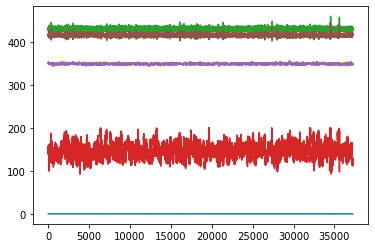

In [2]:
dfRaw = pd.read_excel('Model data.xlsx',engine='openpyxl')
df=dfRaw
print(dfRaw.shape)
print(dfRaw.columns)


d=dfRaw.iloc[:,2:8]

plt.plot(d)
plt.show()

In [3]:
data = dfRaw.copy()
normal_data = data.loc[data["Class"] == 0]
fault_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fault data ", fault_data.shape)
print("Percent fault ", round((len(fault_data)/len(data)), 4),"%")


data  (37229, 9)
normal_data  (37229, 9)
fault data  (0, 9)
Percent fault  0.0 %


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


7
Train on 33506 samples, validate on 3723 samples
Epoch 1/20
33506/33506 [==============================] - 3s 90us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 2/20
33506/33506 [==============================] - 2s 72us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/20
33506/33506 [==============================] - 3s 77us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 8.1909e-04 - val_mean_squared_error: 8.1909e-04
Epoch 4/20
33506/33506 [==============================] - 3s 76us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 7.8648e-04 - val_mean_squared_error: 7.8648e-04
Epoch 5/20
33506/33506 [==============================] - 2s 71us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 6.9055e-04 - val_mean_squared_error: 6.9055e-04
Epoch 6/20
33506/33506 [==============================] - 2s 75us/step - loss: 0.0013 - me

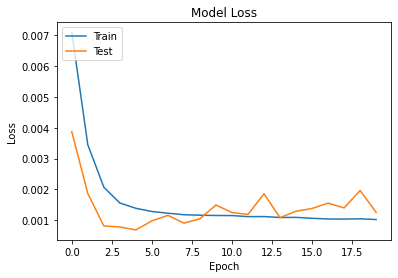

In [4]:

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing





df = pd.read_excel('Model data.xlsx',engine='openpyxl')
# all features
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()


# This portion of code remove anomalies if the dataset contained anomalies

df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]


normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']




# # scaling
scaler = preprocessing.MinMaxScaler()

scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# # 80% percent of dataset is designated to training
train_data, test_data = train_test_split(scaled_data, test_size=0.1)

n_features = x.shape[1]

print(n_features)
# # model
# Add LSTM layers in encoder
encoder = keras.Sequential(name='encoder')
encoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu, input_shape=[n_features]))
encoder.add(keras.layers.Dropout(0.1))
encoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu))
encoder.add(layer=keras.layers.Dense(units=5, activation=keras.activations.relu))

decoder = keras.Sequential(name='decoder')
decoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu, input_shape=[5]))
decoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu))
decoder.add(keras.layers.Dropout(0.1))
decoder.add(layer=keras.layers.Dense(units=n_features, activation=keras.activations.sigmoid))

autoencoder = keras.Sequential([encoder, decoder])

autoencoder.compile(
	loss=keras.losses.MSE,
	optimizer=keras.optimizers.Adam(),
	metrics=[keras.metrics.mean_squared_error])

# train model
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, restore_best_weights=True)
history = autoencoder.fit(x=train_data, y=train_data, epochs=20, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Train on 33506 samples, validate on 3723 samples
Epoch 1/20
33506/33506 [==============================] - 2s 63us/sample - loss: 0.0231 - accuracy: 0.6118 - val_loss: 0.0180 - val_accuracy: 0.8273
Epoch 2/20
33506/33506 [==============================] - 1s 40us/sample - loss: 0.0175 - accuracy: 0.8561 - val_loss: 0.0174 - val_accuracy: 0.8735
Epoch 3/20
33506/33506 [==============================] - 2s 45us/sample - loss: 0.0024 - accuracy: 0.8629 - val_loss: 2.7544e-04 - val_accuracy: 0.8767
Epoch 4/20
33506/33506 [==============================] - 1s 40us/sample - loss: 2.6478e-04 - accuracy: 0.8739 - val_loss: 2.5625e-04 - val_accuracy: 0.8821
Epoch 5/20
33506/33506 [==============================] - 1s 38us/sample - loss: 2.4234e-04 - accuracy: 0.8789 - val_loss: 2.1830e-04 - val_accuracy: 0.8915
Epoch 6/20
33506/33506 [==============================] - 1s 39us/sample - loss: 1.5846e-04 - accuracy: 0.9187 - val_loss: 8.4761e-05 - val_accuracy: 0.9605
Epoch 7/20
33506/33506 [=====

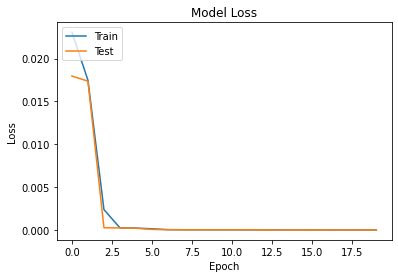

In [9]:

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing

from keras.callbacks import ModelCheckpoint, TensorBoard



df = pd.read_excel('Model data.xlsx',engine='openpyxl')
# all features
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()


# This portion of code remove anomalies if the dataset contained anomalies

df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]


normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']




# # scaling
scaler = preprocessing.MinMaxScaler()

scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# # 80% percent of dataset is designated to training
train_data, test_data = train_test_split(scaled_data, test_size=0.1)

n_features = x.shape[1]

train_x=train_data
test_x=test_data
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)





autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

# history = autoencoder.fit(train_x, train_x,
#                     epochs=nb_epoch,
#                     batch_size=batch_size,
#                     shuffle=True,
#                     validation_data=(test_x, test_x),
#                     verbose=0,
#                     callbacks=[cp, tb]).history


history = autoencoder.fit(x=train_x, y=train_x, epochs=20, verbose=1, validation_data=[test_x, test_x], callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()





# test_x_predictions = autoencoder.predict(test_x)
# mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
# error_df = pd.DataFrame({'Reconstruction_error': mse})
# error_df.describe()




/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


------------------------------------------------------------------------
Training for fold 0 ...
Train on 29783 samples, validate on 3723 samples
Epoch 1/50
29783/29783 [==============================] - 3s 92us/step - loss: 0.0080 - mean_squared_error: 0.0080 - accuracy: 0.4774 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_accuracy: 0.7429
Epoch 2/50
29783/29783 [==============================] - 2s 65us/step - loss: 0.0033 - mean_squared_error: 0.0033 - accuracy: 0.6913 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - val_accuracy: 0.7932
Epoch 3/50
29783/29783 [==============================] - 2s 64us/step - loss: 0.0029 - mean_squared_error: 0.0029 - accuracy: 0.7173 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_accuracy: 0.8037
Epoch 4/50
29783/29783 [==============================] - 2s 64us/step - loss: 0.0027 - mean_squared_error: 0.0027 - accuracy: 0.7288 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_accuracy: 0.7959
Epoch 5/50
29783/2

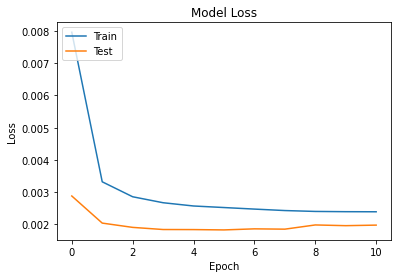

------------------------------------------------------------------------
Training for fold 1 ...
Train on 29783 samples, validate on 3723 samples
Epoch 1/50
29783/29783 [==============================] - 3s 91us/step - loss: 0.0099 - mean_squared_error: 0.0099 - accuracy: 0.3941 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_accuracy: 0.4214
Epoch 2/50
29783/29783 [==============================] - 2s 64us/step - loss: 0.0054 - mean_squared_error: 0.0054 - accuracy: 0.5358 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_accuracy: 0.7037
Epoch 3/50
29783/29783 [==============================] - 2s 64us/step - loss: 0.0030 - mean_squared_error: 0.0030 - accuracy: 0.7050 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - val_accuracy: 0.7698
Epoch 4/50
29783/29783 [==============================] - 2s 64us/step - loss: 0.0027 - mean_squared_error: 0.0027 - accuracy: 0.7228 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_accuracy: 0.7814
Epoch 5/50
29783/2

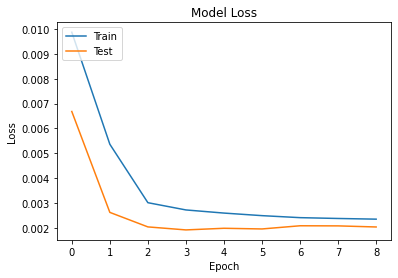

------------------------------------------------------------------------
Training for fold 2 ...
Train on 29783 samples, validate on 3723 samples
Epoch 1/50
29783/29783 [==============================] - 3s 92us/step - loss: 0.0079 - mean_squared_error: 0.0079 - accuracy: 0.4948 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_accuracy: 0.6132
Epoch 2/50
29783/29783 [==============================] - 2s 65us/step - loss: 0.0051 - mean_squared_error: 0.0051 - accuracy: 0.5770 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_accuracy: 0.6138
Epoch 3/50
29783/29783 [==============================] - 2s 65us/step - loss: 0.0048 - mean_squared_error: 0.0048 - accuracy: 0.5959 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_accuracy: 0.6121
Epoch 4/50
29783/29783 [==============================] - 2s 65us/step - loss: 0.0047 - mean_squared_error: 0.0047 - accuracy: 0.6026 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_accuracy: 0.6213
Epoch 5/50
29783/2

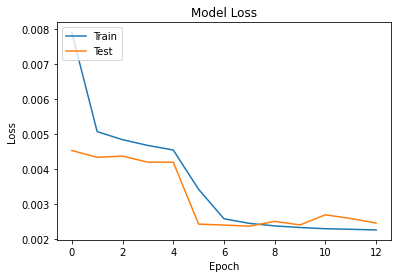

------------------------------------------------------------------------
Training for fold 3 ...
Train on 29783 samples, validate on 3723 samples
Epoch 1/50
29783/29783 [==============================] - 3s 91us/step - loss: 0.0073 - mean_squared_error: 0.0073 - accuracy: 0.5728 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_accuracy: 0.7717
Epoch 2/50
29783/29783 [==============================] - 2s 64us/step - loss: 0.0033 - mean_squared_error: 0.0033 - accuracy: 0.7028 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_accuracy: 0.7644
Epoch 3/50
29783/29783 [==============================] - 2s 64us/step - loss: 0.0028 - mean_squared_error: 0.0028 - accuracy: 0.7152 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_accuracy: 0.7532
Epoch 4/50
29783/29783 [==============================] - 2s 64us/step - loss: 0.0026 - mean_squared_error: 0.0026 - accuracy: 0.7276 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_accuracy: 0.7698
Epoch 5/50
29783/2

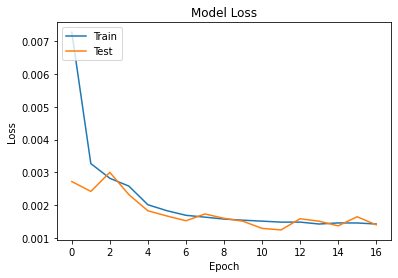

------------------------------------------------------------------------
Training for fold 4 ...
Train on 29784 samples, validate on 3723 samples
Epoch 1/50
29784/29784 [==============================] - 3s 91us/step - loss: 0.0069 - mean_squared_error: 0.0069 - accuracy: 0.4551 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_accuracy: 0.5624
Epoch 2/50
29784/29784 [==============================] - 2s 64us/step - loss: 0.0040 - mean_squared_error: 0.0040 - accuracy: 0.5818 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_accuracy: 0.7045
Epoch 3/50
29784/29784 [==============================] - 2s 64us/step - loss: 0.0029 - mean_squared_error: 0.0029 - accuracy: 0.7015 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_accuracy: 0.7698
Epoch 4/50
29784/29784 [==============================] - 2s 65us/step - loss: 0.0025 - mean_squared_error: 0.0025 - accuracy: 0.7386 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - val_accuracy: 0.7585
Epoch 5/50
29784/2

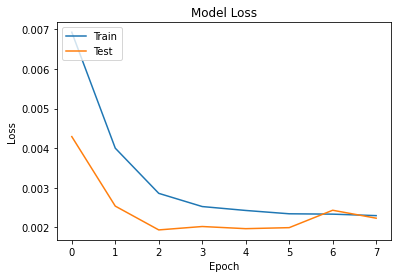

> Loss: 0.0018760842465676125


In [6]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.model_selection import train_test_split
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
import scipy


from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing
from sklearn.model_selection import KFold


df = pd.read_excel('Model data.xlsx',engine='openpyxl')
# all features
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()


# This portion of code remove anomalies if the dataset contained anomalies

df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]


normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']




# # scaling
scaler = preprocessing.MinMaxScaler()

scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# # 80% percent of dataset is designated to training
train_data, test_data = train_test_split(scaled_data, test_size=0.1)
n_features = x.shape[1]

inputs = np.concatenate((train_data, test_data), axis=0)


# Define the K-fold Cross Validator
num_folds=5
kfold = KFold(n_splits=num_folds, shuffle=True)


prediction_loss_error=[]

i=0

for train, test in kfold.split(inputs):
    
    # # model
    encoder = keras.Sequential(name='encoder')
    encoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu, input_shape=[n_features]))
    encoder.add(keras.layers.Dropout(0.1))
    encoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu))
    encoder.add(layer=keras.layers.Dense(units=5, activation=keras.activations.relu))

    decoder = keras.Sequential(name='decoder')
    decoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu, input_shape=[5]))
    decoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu))
    decoder.add(keras.layers.Dropout(0.1))
    decoder.add(layer=keras.layers.Dense(units=n_features, activation=keras.activations.sigmoid))

    autoencoder = keras.Sequential([encoder, decoder])

    autoencoder.compile(
        loss=keras.losses.MSE,
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.mean_squared_error,'accuracy'])
    

    # train model
    es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, restore_best_weights=True)
#     history = autoencoder.fit(x=train_data, y=train_data, epochs=100, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
    
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {i} ...')

    # Fit data to model
    history = autoencoder.fit(x=inputs[train], y=inputs[train], epochs=50, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
    
    
    # Mean Squared error
    train_predicted_x = autoencoder.predict(x=inputs[train])
    train_events_mse=sklearn.metrics.mean_squared_error(inputs[train], train_predicted_x)
    prediction_loss_error.append(train_events_mse)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    i=i+1


# Increase fold number
i = i + 1

print(f'> Loss: {np.mean(prediction_loss_error)}')

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MSE
7.470441232726444e-05
2.5163035e-05


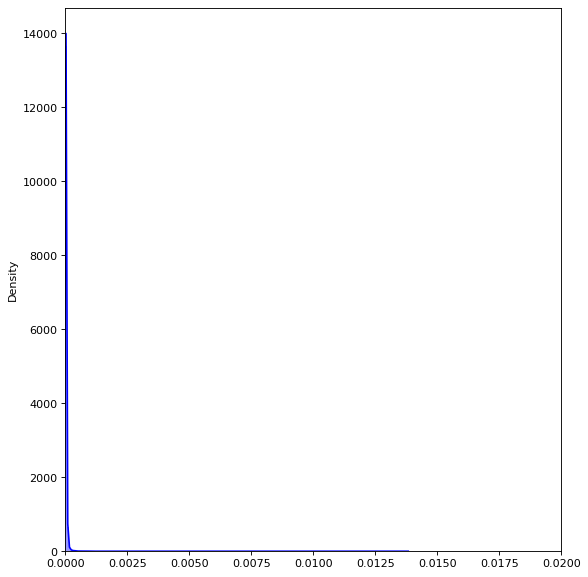

In [10]:

# Mean Squared error
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mse = keras.losses.mean_squared_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

# loss distribution

plt.figure(figsize=(8,9), dpi=80)
sns.distplot(train_events_mse, bins=200, kde=True, color='blue')
plt.xlim([0., .02]);


print('MSE')
print(cut_off)
print(np.average(train_events_mse.numpy()))



# # Mean Absolute error
# train_predicted_x = autoencoder.predict(x=train_data)
# train_events_mae = keras.losses.mean_absolute_percentage_error(train_data, train_predicted_x)
# cut_off = np.percentile(train_events_mae, 95)


# # loss distribution

# plt.figure(figsize=(8,9), dpi=80)
# sns.distplot(train_events_mae, bins=2000, kde=True, color='blue')
# plt.xlim([0., 50000]);


# print('')
# print('MAE')
# print(cut_off)
# print(np.average(train_events_mae.numpy()))


# # Mean Log error
# train_predicted_x = autoencoder.predict(x=train_data)
# train_events_mle = keras.losses.mean_squared_logarithmic_error(train_data, train_predicted_x)
# cut_off = np.percentile(train_events_mle, 95)

# # loss distribution

# plt.figure(figsize=(8,9), dpi=80)
# sns.distplot(train_events_mle, bins=200, kde=True, color='blue')
# plt.xlim([0., .02]);

# print('')
# print('MLE')
# print(cut_off)
# print(np.average(train_events_mle.numpy()))



         Var2_ 5   Var2_ 6     Var2_ 7     Var2_ 8     Var2_ 9     Var2_10  \
0     346.246429  0.097839  430.908339  148.557666  738.857235  416.479319   
1     345.999944 -0.000093  619.680723  200.131641  738.536140  645.686550   
2     346.523751 -0.000418  654.320938  200.157415  738.759351  672.560695   
3     346.171236  0.000081  661.077056  200.309578  738.904264  678.504342   
4     346.426409  0.000257  660.361872  199.149727  738.863967  677.679745   
...          ...       ...         ...         ...         ...         ...   
1196  350.848120  0.085220  435.628666  174.058373  349.747014  418.221587   
1197  350.672596  0.121884  427.093022  167.369589  350.292807  412.280468   
1198  351.076688  0.094359  434.076449  169.750646  350.403221  417.613511   
1199  350.747285  0.115480  428.336561  166.263332  350.397636  413.587566   
1200  352.103004  0.110990  430.025948  155.097616  349.470731  415.654411   

      Class  
0         0  
1         1  
2         1  
3      

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

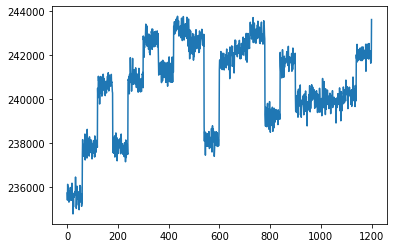

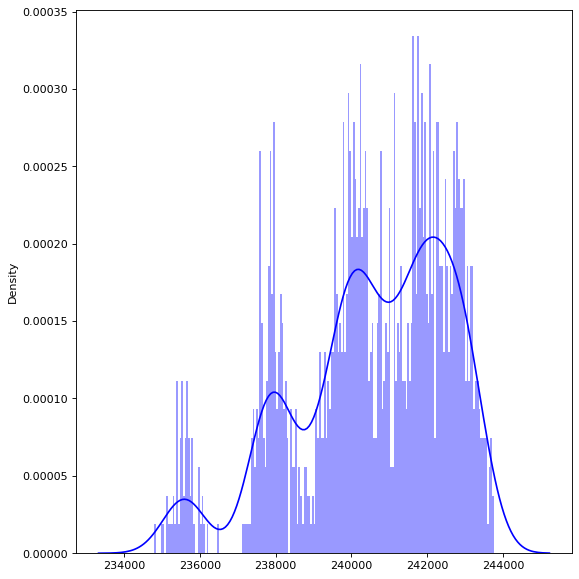

In [13]:
# Import dataset whihc has a fault to be detected

df = pd.read_excel('Tci Fault up.xlsx',engine='openpyxl')
# df=df.iloc[:,2:8]
# plt.plot(df)




plot_samples=1201
# all features
x = df[df.columns[2:9]].to_numpy()
print(df[df.columns[2:9]])
print(x.shape[1])
# column with class
y = df[df.columns[1]].to_numpy()



# Creating a data frame and calling the class "Anomaly"
abnormal_events = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

# abnormal event
abnormal_x = scaler.transform(abnormal_events).reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
    
	'n': np.arange(0, plot_samples),    
	'mse': abnormal_events_mse})


Final=pd.DataFrame(abnormal_events_df.mse)

Final['cutoff']=0.001

print(Final)
plt.plot(abnormal_events_df.mse)


# abnormal_events_df.to_excel('test4.xlsx')


plt.figure(figsize=(8,9), dpi=80)
sns.distplot(abnormal_events_mse, bins=200, kde=True, color='blue')
;

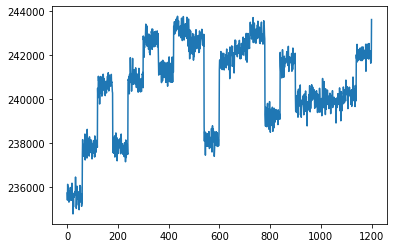

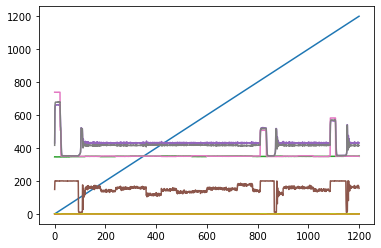

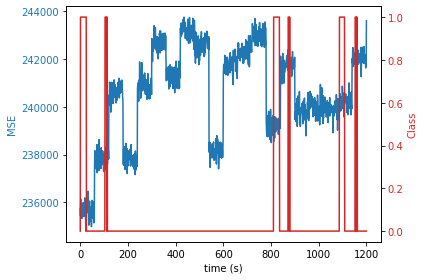

In [14]:
import numpy as np
import matplotlib.pyplot as plt



plt.plot(abnormal_events_df.mse)
plt.show()
df = pd.read_excel('Tci Fault up.xlsx',engine='openpyxl')
plt.plot(df)
plt.show()


df=df.Class
data1 = abnormal_events_mse
data2 = df

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MSE', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Class', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()